## Differential programming

#### Python packages
* PyTorch
* Tensorflow

#### Julia packages
* Zygote.jl
* Flux.jl
* KNet.jl

You can find them on github.

In [ ]:
using Zygote: gradient

In [ ]:
N =  10

A = randn(ComplexF64, N, N); A = A+A'

In [ ]:
using LinearAlgebra

E, V = eigen(A)
@show E[1]

In [ ]:
f(x) = real(x'*A*x/(x'*x))[]

x = randn(ComplexF64, N)
α = 0.1

for i = 1:100
    g = f'(x)
    x -= α .* g
    println("Energy is $(f(x))")
end

In [ ]:
#using Yao, Yao.Blocks, Yao.Intrinsics # for v0.3.x
using Yao
using Random
using PyPlot
Random.seed!(2);

## A Simple Example: QFT Algorithm
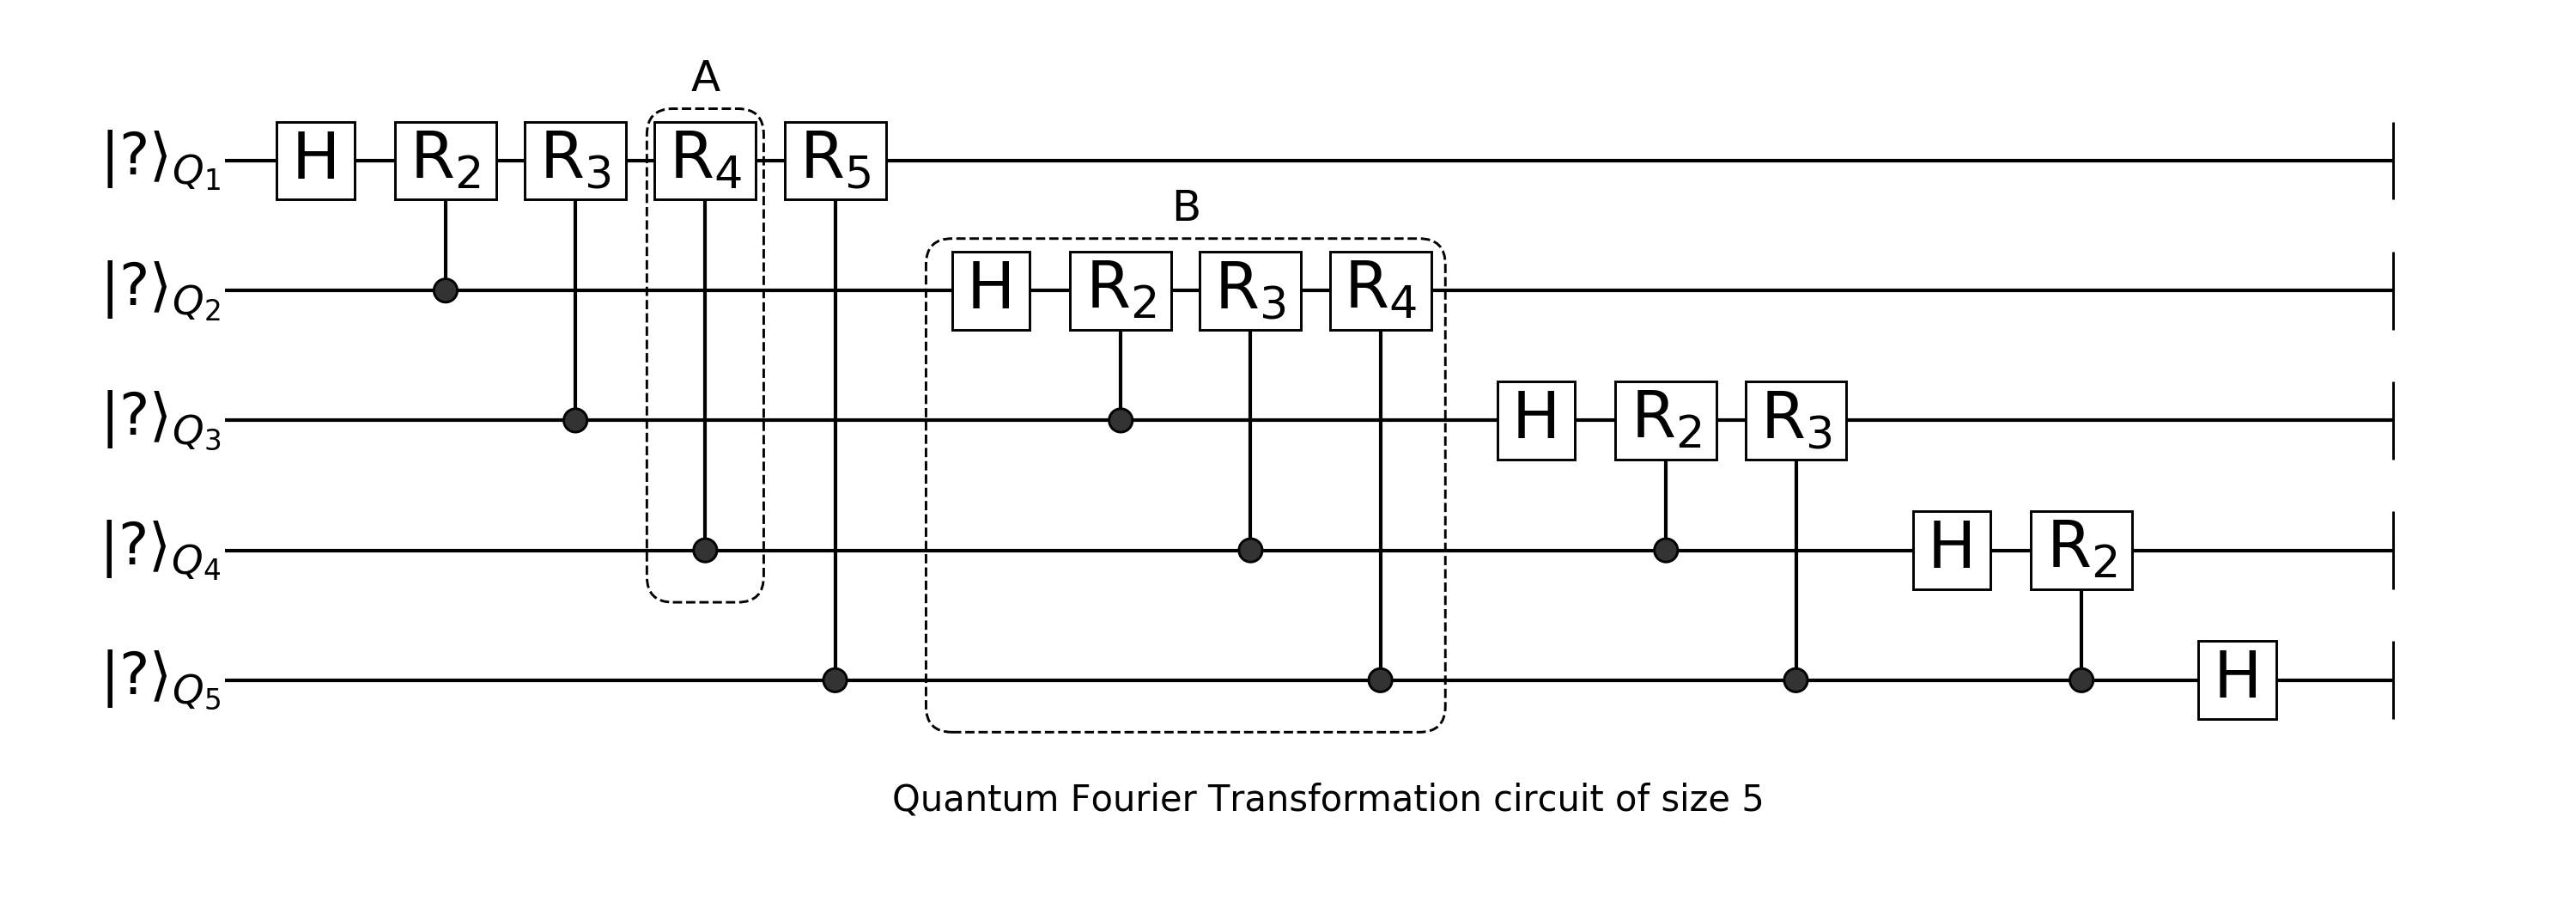

In [ ]:
CRk(i::Int, j::Int, k::Int) = control([i, ], j=>shift(2π/(1<<k)))
CRot(n::Int, i::Int) = chain(n, i==j ? kron(i=>H) : CRk(j, i, j-i+1) for j = i:n)
QFTCircuit(n::Int) = chain(n, CRot(n, i) for i = 1:n)

qft = QFTCircuit(5)

In [ ]:
iqft = qft'

In [ ]:
reg = rand_state(5)
copy(reg) |> qft |> iqft ≈ reg

# The landscape of a quantum circuit

Here, $V_{1j}^{(n)}$ and $V_{2j}^{(n)}$ are two random circuits. $R_j(\theta_j)$ is a rotation gate defined as $R_j(\theta_j) = e^{-i\Sigma_j \theta_j/2}$ with $\Sigma_j^2 = 1$.

> Nakanishi, Ken M., Keisuke Fujii, and Synge Todo. "Sequential minimal optimization for quantum-classical hybrid algorithms." arXiv preprint arXiv:1903.12166 (2019).

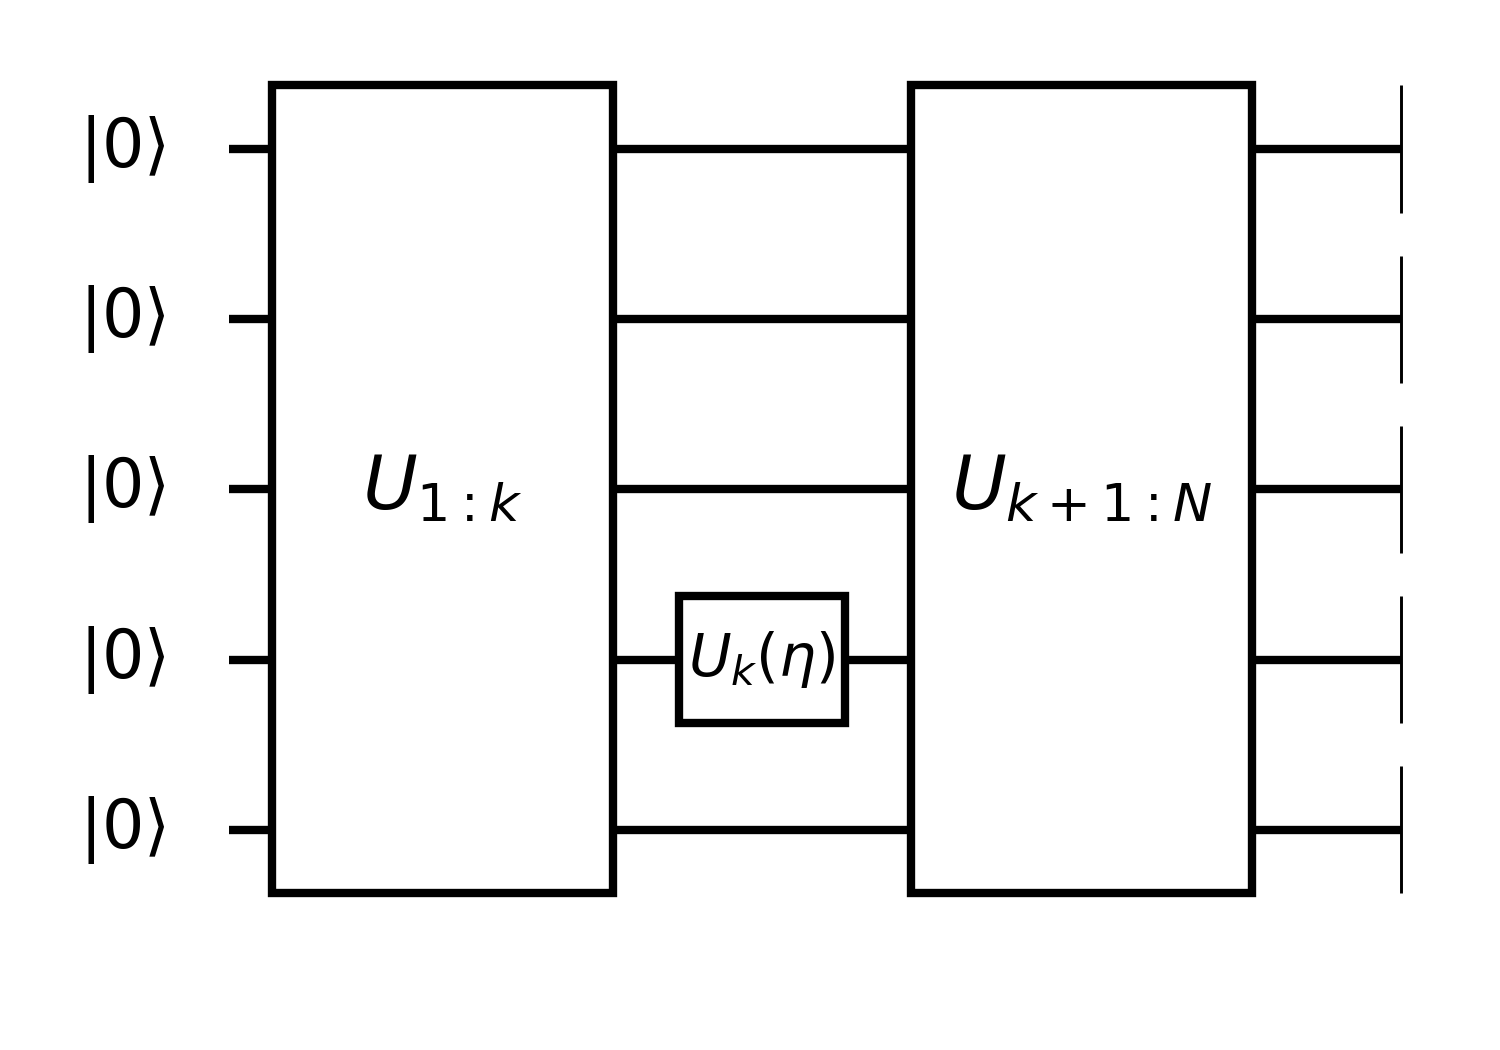

In [ ]:
function scan_params(Uj, observable, nparam::Int)
    x = LinRange(0, 2π, nparam)
    y = zeros(nparam)
    for (i,x) in enumerate(x)
        dispatch!(Uj, x)
        y[i] = expect(observable, zero_state(N) |> c) |> real
    end
    x, y
end

N = 5

V1j = rand_unitary(1<<N) |> matrixgate
V2j = rand_unitary(1<<N) |> matrixgate

Uj = put(N, 4=>Rx(0.0))
c = chain(N, [V1j, Uj, V2j])

observable = put(N, 4=>Z)
xs, ys = scan_params(Uj, observable, 100)

# see a sine curve
ax = plot(xs, ys)

In [ ]:
using Statistics

function rand_gradient(N::Int)
    observable = put(N, 1=>Z)
    
    V1j = rand_unitary(1<<N) |> matrixgate
    V2j = rand_unitary(1<<N) |> matrixgate

    Uj = put(N, 1=>Rx(0.0))
    c = chain(N, [V1j, Uj, V2j])
    
    η = rand()*2π
    dispatch!(Uj, η+π/2)
    y₊ = expect(observable, zero_state(N) |> c) |> real

    dispatch!(Uj, η-π/2)
    y₋ = expect(observable, zero_state(N) |> c) |> real
    (y₊ - y₋)/2
end

maxN = 9
grad_vars = [mean([abs(rand_gradient(N)) for i=1:100]) for N=1:maxN]

# see a sine curve
ax = plot(1:maxN, grad_vars)
yscale("log")